In [1]:
from census import Census
from config import census_key, tamu_key
from us import states
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly
import pprint
import requests
import scipy
import seaborn as sns
import time
from scipy import stats

In [9]:
bus_stops_path = os.path.join("capmetro", "stops.csv")
bus_stops_csv = pd.read_csv(bus_stops_path, header=0)
bus_stops_master_df = pd.DataFrame(bus_stops_csv)

In [10]:
bus_stops_df = bus_stops_master_df[["stop_name", "stop_lat", "stop_lon"]]

In [11]:
capmetro_bus_stops_df = bus_stops_df.rename(columns= {"stop_lat": "lat", "stop_lon": "lon"})

In [12]:
capmetro_bus_stops_df

,stop_name,lat,lon
0,Rio Grande/15th,30.278966,-97.746339
1,8740 Lamar/Payton Gin,30.356809,-97.701066
2,Fairfield Station (SB),30.355296,-97.703128
3,Lamar/Thurmond,30.353139,-97.706082
4,8320 Lamar/Meadowlark,30.352256,-97.707295
...,...,...,...
2406,Norwood Transit Center,30.340154,-97.691472
2407,10099 Burnet/Mc Hale,30.385221,-97.723575
2408,2007 Pleasant Valley/Riverside,30.233492,-97.724007
2409,MLK Jr Station,30.279442,-97.709643


In [13]:
version = "4.10"
url= "https://geoservices.tamu.edu/Services/ReverseGeocoding/WebService/v04_01/HTTP/default.aspx"

bus_stops_geocode = []

for lat, lon in zip(capmetro_bus_stops_df['lat'], capmetro_bus_stops_df['lon']):
    payload = {
        "apiKey": tamu_key,
        "version": version,
        "format": "json",
        "lat": lat,
        "lon": lon}

    r = requests.get(url, params= payload).json()
    bus_stops_geocode.append(r)

In [14]:
bus_zip_codes = []
for x in range(len(bus_stops_geocode)):
    bus_zip_code_result = bus_stops_geocode[x]["StreetAddresses"][0]["Zip"]
    bus_zip_codes.append(bus_zip_code_result)

In [15]:
capmetro_bus_stops_df["Zip_Codes"] = bus_zip_codes

In [16]:
capmetro_bus_stops_df["Zip_Codes"].unique()

array(['78701', '78753', '78757', '78752', '78751', '78705', '78704',
       '78745', '78744', '78721', '78702', '78756', '78703', '78741',
       '78723', '78722', '78724', '78749', '78731', '78759', '78746',
       '78754', '78758', '78735', '78736', '78748', '78645', '78727',
       '78617', '78750', '78729', '78717', '78660', '78728', '78641',
       '78621', '78613', '78747', '78653', '78737', '78739', '78664',
       '78681', '78665'], dtype=object)

In [17]:
capmetro_bus_stops_df

,stop_name,lat,lon,Zip_Codes
0,Rio Grande/15th,30.278966,-97.746339,78701
1,8740 Lamar/Payton Gin,30.356809,-97.701066,78753
2,Fairfield Station (SB),30.355296,-97.703128,78753
3,Lamar/Thurmond,30.353139,-97.706082,78753
4,8320 Lamar/Meadowlark,30.352256,-97.707295,78753
...,...,...,...,...
2406,Norwood Transit Center,30.340154,-97.691472,78753
2407,10099 Burnet/Mc Hale,30.385221,-97.723575,78758
2408,2007 Pleasant Valley/Riverside,30.233492,-97.724007,78741
2409,MLK Jr Station,30.279442,-97.709643,78702


In [18]:
capmetro_bus_stops_df.to_csv("bus_stops_zips.csv", index= False)

In [3]:
bus_path = os.path.join("bus_stops_zips.csv")
bus_df = pd.read_csv("bus_stops_zips.csv")

In [4]:
bus_df

,stop_name,lat,lon,Zip_Codes
0,Rio Grande/15th,30.278966,-97.746339,78701
1,8740 Lamar/Payton Gin,30.356809,-97.701066,78753
2,Fairfield Station (SB),30.355296,-97.703128,78753
3,Lamar/Thurmond,30.353139,-97.706082,78753
4,8320 Lamar/Meadowlark,30.352256,-97.707295,78753
...,...,...,...,...
2406,Norwood Transit Center,30.340154,-97.691472,78753
2407,10099 Burnet/Mc Hale,30.385221,-97.723575,78758
2408,2007 Pleasant Valley/Riverside,30.233492,-97.724007,78741
2409,MLK Jr Station,30.279442,-97.709643,78702


In [5]:
c = Census(census_key , year=2017)

In [6]:
census_data = c.acs5.get(("B01003_001E", 
                          "B17001_002E",
                          "B08201_002E",
                          "B08301_018E",
                          "B08301_011E",
                          "B08301_019E",
                          "B08301_017E",
                          "B08301_021E",
                          "B08301_004E",
                          "B08301_003E",
                          "B08301_020E",
                          "B25001_001E"),
                        {'for':'zip code tabulation area:*'})

census_pd = pd.DataFrame(census_data)

census_pd = census_pd.rename(columns={"B01003_001E":"Population",
                                      "B17001_002E": "Poverty_Count",
                                      "zip code tabulation area":"Zip_Codes",
                                      "B08201_002E":"HH_No_Vehicles",
                                      "B08301_018E": "Work_Pop_Bike",
                                      "B08301_011E": "Work_Pop_Bus",
                                      "B08301_019E": "Work_Pop_Walk",
                                      "B08301_017E": "Work_Pop_Motorcycle",
                                      "B08301_021E":"Work_Pop_Telework",
                                      "B08301_004E":"Work_Pop_Carpooled",
                                      "B08301_003E":"Work_Pop_Drove alone",
                                      "B08301_020E":"Work_Pop_Other",
                                      "B25001_001E":"Housing_Units"})

census_pd['Poverty_Rate'] = census_pd['Poverty_Count'].astype(int)/census_pd['Population'].astype(int) * 100
census_pd['Zip_Codes'] = census_pd['Zip_Codes'].astype(str).astype(int)

In [7]:
dataTypeObj = bus_df.dtypes['Zip_Codes']
master_df = pd.merge(census_pd, bus_df, on = 'Zip_Codes', how = 'inner')

In [8]:
master_df

,Population,Poverty_Count,HH_No_Vehicles,Work_Pop_Bike,Work_Pop_Bus,Work_Pop_Walk,Work_Pop_Motorcycle,Work_Pop_Telework,Work_Pop_Carpooled,Work_Pop_Drove alone,Work_Pop_Other,Housing_Units,Zip_Codes,Poverty_Rate,stop_name,lat,lon
0,77779.0,2943.0,565.0,167.0,210.0,246.0,51.0,3613.0,3168.0,31084.0,229.0,26780.0,78613,3.783798,ACC Cypress Creek,30.479477,-97.834422
1,27900.0,4815.0,162.0,22.0,149.0,80.0,88.0,216.0,2020.0,9006.0,118.0,7244.0,78617,17.258065,Travis Correctional Facility,30.197840,-97.645546
2,27900.0,4815.0,162.0,22.0,149.0,80.0,88.0,216.0,2020.0,9006.0,118.0,7244.0,78617,17.258065,3103 SH 71/Cheviot,30.205035,-97.642589
3,27900.0,4815.0,162.0,22.0,149.0,80.0,88.0,216.0,2020.0,9006.0,118.0,7244.0,78617,17.258065,2777 SH 71/Golf Course,30.210895,-97.654067
4,27900.0,4815.0,162.0,22.0,149.0,80.0,88.0,216.0,2020.0,9006.0,118.0,7244.0,78617,17.258065,3320 FM 973/SH 71,30.200884,-97.640493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2406,41847.0,2238.0,873.0,95.0,536.0,294.0,235.0,2905.0,1426.0,18586.0,171.0,21798.0,78759,5.348054,Braker/Mopac (Farside/Midblock),30.397553,-97.736066
2407,41847.0,2238.0,873.0,95.0,536.0,294.0,235.0,2905.0,1426.0,18586.0,171.0,21798.0,78759,5.348054,Esperanza Crossing/Domain,30.399880,-97.724385
2408,41847.0,2238.0,873.0,95.0,536.0,294.0,235.0,2905.0,1426.0,18586.0,171.0,21798.0,78759,5.348054,10001 Stonelake/Capital of Texas,30.391198,-97.739283
2409,41847.0,2238.0,873.0,95.0,536.0,294.0,235.0,2905.0,1426.0,18586.0,171.0,21798.0,78759,5.348054,Mopac/Braker,30.393962,-97.732447


## Plot DataFrame

In [9]:
zip_code_data = master_df.loc[:, ["Zip_Codes", "Poverty_Count", "Work_Pop_Bus", "Poverty_Rate"]].drop_duplicates()
bus_stop_count = master_df.groupby('Zip_Codes').count()['stop_name']

plot_data = pd.merge(bus_stop_count, zip_code_data, on = ('Zip_Codes','Zip_Codes'), how = 'inner')

plot_data.columns= ["Zip_Codes","Bus_Stop_Quantity","Poverty_Count", "Work_Pop_Bus", "Poverty_Rate"]

df = plot_data
df.head()

,Zip_Codes,Bus_Stop_Quantity,Poverty_Count,Work_Pop_Bus,Poverty_Rate
0,78613,1,2943.0,210.0,3.783798
1,78617,22,4815.0,149.0,17.258065
2,78621,2,3447.0,0.0,15.484480
3,78641,4,3892.0,163.0,6.472104
4,78645,17,741.0,36.0,6.921999


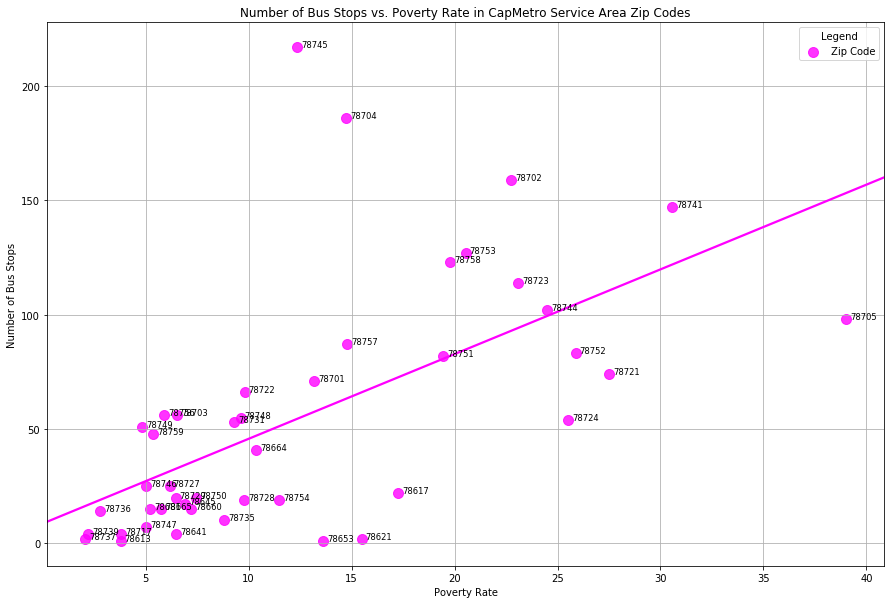

In [15]:
plt.figure(figsize = (15,10))

poverty_count_plot = sns.regplot(data= df, x= "Poverty_Rate", y= "Bus_Stop_Quantity", marker= "o", scatter_kws={'s':100}, ci=None, label= "Zip Code", color= "#ff00ff")

# add annotations one by one with a loop
for line in range(0, df.shape[0]):
     poverty_count_plot.text(df.Poverty_Rate[line] + 0.2, df.Bus_Stop_Quantity[line], df.Zip_Codes[line], horizontalalignment= 'left', size= 'small', color= "black")

plt.grid()
plt.legend(title= "Legend", loc= "upper right")
plt.title("Number of Bus Stops vs. Poverty Rate in CapMetro Service Area Zip Codes")
plt.xlabel("Poverty Rate")
plt.ylabel("Number of Bus Stops")
           
plt.savefig("Bus_Stop_VS_Poverty_Rate.png")

plt.show()
plt.close()

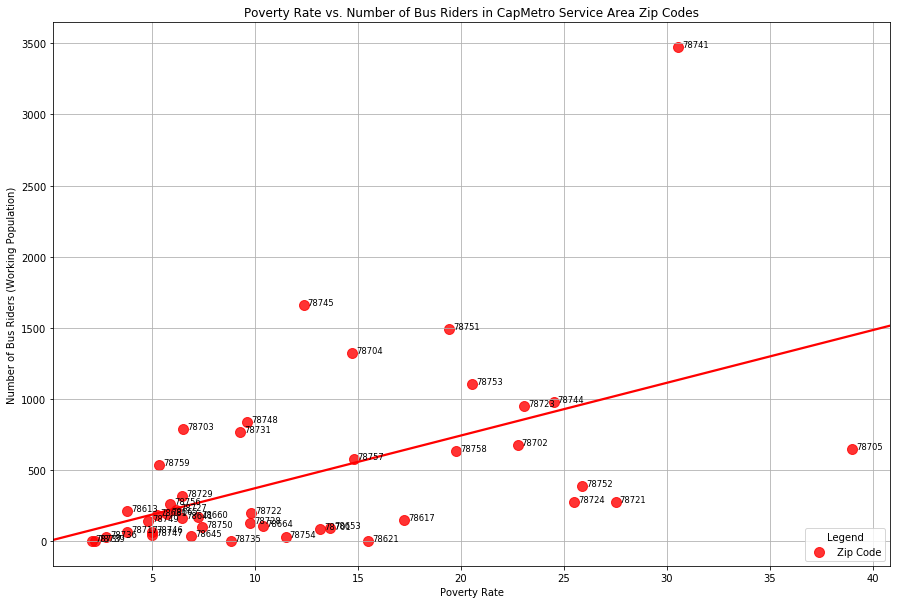

In [16]:
plt.figure(figsize = (15,10))
poverty_count_plot = sns.regplot(data= df, x= "Poverty_Rate", y= "Work_Pop_Bus", marker= "o", scatter_kws={'s':100}, ci=None, label= "Zip Code", color= "#ff0000")

# add annotations one by one with a loop
for line in range(0, df.shape[0]):
     poverty_count_plot.text(df.Poverty_Rate[line] + 0.2, df.Work_Pop_Bus[line], df.Zip_Codes[line], horizontalalignment= 'left', size= 'small', color= "black")

plt.grid()
plt.legend(title= "Legend", loc= "lower right")
plt.title("Poverty Rate vs. Number of Bus Riders in CapMetro Service Area Zip Codes")
plt.xlabel("Poverty Rate")
plt.ylabel("Number of Bus Riders (Working Population)")
           
plt.savefig("Poverty_Rate_VS_Bus_Riders.png")

plt.show()
plt.close()